In [1]:
from ddks.data import *
from ddks.data.openimages_dataset import LS
from ddks import methods
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import tqdm
import pickle
import os

import matplotlib as mpl
plt.style.use('ah')
plt.show()
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', ['348ABD','E24A33', '988ED5', '777777', 'FBC15E', '8EBA42', 'FFB5B8'])


In [2]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


In [3]:
methods_list = [methods.ddks_method,  methods.vdks_method, methods.rdks_method]
datasets = [GVM, GVS, DVU, Skew, MM]

def within(x, y, eps=1.0E-3):
    return np.abs(x - y) < eps

def return_mean_significance(_method, Dataset, dimension, sample_size, permutations=100):
    _dataset = Dataset(dimension=dimension, sample_size=sample_size)
    p, t = next(_dataset)
    return _method(p, t, permutations)

def bisection(_method, Dataset, dimension, permutations=100, trials=10, max_sample_size=500):
    mids = []
    for i in tqdm.tqdm(np.arange(trials)):
        low = 2
        high = 100
        mid = int((low + high) / 2)
        low_sig = return_mean_significance(_method, Dataset, dimension, low, permutations)
        high_sig = return_mean_significance(_method, Dataset, dimension, high, permutations)
        mid_sig = return_mean_significance(_method, Dataset, dimension, mid, permutations)
        significance = 1.0
        while not within(mid_sig, 0.05):
            if (high - low) <= 2:
                if (np.abs(high_sig - 0.05) < np.abs(mid_sig - 0.05)) \
                        and (np.abs(high_sig - 0.05) < np.abs(low_sig - 0.05)):
                    mid = high
                    mid_sig = high_sig
                elif (np.abs(low_sig - 0.05) < np.abs(mid_sig - 0.05)) \
                        and (np.abs(low_sig - 0.05) < np.abs(mid_sig - 0.05)):
                    mid = low
                    mid_sig = low_sig
                break
            if low_sig > 0.05 and mid_sig < 0.05:
                new_mid = int((low + mid) / 2)
                high = mid
                high_sig = mid_sig
                mid = new_mid
                mid_sig = return_mean_significance(_method, Dataset, dimension, mid, permutations)
            elif mid_sig > 0.05 and high_sig < 0.05:
                new_mid = int((mid + high) / 2)
                low = mid
                low_sig = mid_sig
                mid = new_mid
                mid_sig = return_mean_significance(_method, Dataset, dimension, mid, permutations)
            else:
                if high < max_sample_size:
                    high = high + 50
                    mid = int((low + high) / 2)
                    low_sig = return_mean_significance(_method, Dataset, dimension, low, permutations)
                    high_sig = return_mean_significance(_method, Dataset, dimension, high, permutations)
                    mid_sig = return_mean_significance(_method, Dataset, dimension, mid, permutations)
                else:
                    mid = np.nan
                    break
        mids.append(mid)
    

    return np.nanmean(mids), np.nanstd(mids), np.sum(np.isfinite(mids))
        

In [4]:

if os.path.exists('ddks_sample_sizes_xdks.pkl'):
    data = pickle.load(open('ddks_sample_sizes_xdks.pkl', 'rb'))
else:
    data = {}
for dataset in datasets:
    data[str(dataset)] = dict()
    for metric in methods_list:
        #if 'rdKS' not in metric.name:
        #    continue
        if metric.name in list(data[str(dataset)].keys()):
            continue
        data[str(dataset)][metric.name] = bisection(metric, dataset, dimension=3)
        print(str(dataset), metric.name, data[str(dataset)][metric.name])
    pickle.dump(data, open('ddks_sample_sizes_xdks.pkl', 'wb'))


  0%|          | 0/10 [00:00<?, ?it/s]

<class 'ddks.data.GVM'> ddKS (11.9, 3.806573262134856, 10)


  0%|          | 0/10 [00:00<?, ?it/s]

<class 'ddks.data.GVM'> vdKS (9.5, 2.29128784747792, 10)


  0%|          | 0/10 [00:00<?, ?it/s]

<class 'ddks.data.GVM'> rdKS (11.4, 2.939387691339814, 10)


  0%|          | 0/10 [00:00<?, ?it/s]

<class 'ddks.data.GVS'> ddKS (24.2, 4.833218389437829, 10)


  0%|          | 0/10 [00:00<?, ?it/s]

<class 'ddks.data.GVS'> vdKS (29.3, 6.885491994040804, 10)


  0%|          | 0/10 [00:00<?, ?it/s]

<class 'ddks.data.GVS'> rdKS (34.3, 9.920181449953423, 10)


  0%|          | 0/10 [00:00<?, ?it/s]

<class 'ddks.data.DVU'> ddKS (17.5, 7.379024325749306, 10)


  0%|          | 0/10 [00:00<?, ?it/s]

<class 'ddks.data.DVU'> vdKS (15.6, 3.006659275674582, 10)


  0%|          | 0/10 [00:00<?, ?it/s]

<class 'ddks.data.DVU'> rdKS (30.5, 3.721558813185679, 10)


  0%|          | 0/10 [00:00<?, ?it/s]

<class 'ddks.data.Skew'> ddKS (23.1, 8.41961994391671, 10)


  0%|          | 0/10 [00:00<?, ?it/s]

<class 'ddks.data.Skew'> vdKS (22.2, 8.634813257969162, 10)


  0%|          | 0/10 [00:00<?, ?it/s]

<class 'ddks.data.Skew'> rdKS (17.7, 5.367494760127856, 10)


  0%|          | 0/10 [00:00<?, ?it/s]

<class 'ddks.data.MM'> ddKS (43.3, 23.84135063288152, 10)


  0%|          | 0/10 [00:00<?, ?it/s]

<class 'ddks.data.MM'> vdKS (41.2, 9.589577675789482, 10)


100%|██████████| 10/10 [04:21<00:00, 26.12s/it]

<class 'ddks.data.MM'> rdKS (37.0, 11.072488428533127, 10)


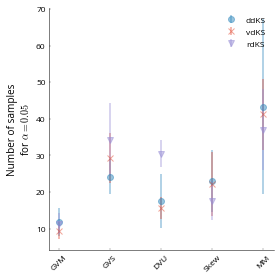

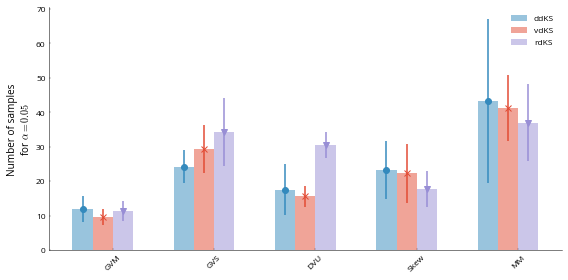

In [5]:

fig = plt.figure(figsize=(4, 4))
markers = ['o', 'x', 'v', '^']
#gvm
for metric, marker in zip(data[list(data.keys())[0]].keys(), markers):
    means = [data[_dataset][metric][0] for _dataset in data.keys()]
    stds = [data[_dataset][metric][1] for _dataset in data.keys()]
    plt.errorbar(np.arange(len(means)), means, yerr=stds, linestyle='none', marker=marker, label=metric, alpha=0.5)
plt.xticks(np.arange(len(datasets)), ['GVM', 'GVS', 'DVU', 'Skew', 'MM', 'LS'], rotation=45)
plt.ylabel('Number of samples' + "\n" + r'for $\alpha=0.05$')
plt.legend()
plt.show()

fig = plt.figure(figsize=(8, 4))
markers = ['o', 'x', 'v', '^']
#gvm
for i, (metric, marker) in enumerate(zip(data[list(data.keys())[0]].keys(), markers)):
    means = [data[_dataset][metric][0] for _dataset in data.keys()]
    stds = [data[_dataset][metric][1] for _dataset in data.keys()]
    plt.bar(np.arange(len(means)) + (i/5.0 - 0.5), means, label=metric, width=0.20, alpha=0.5)
    plt.errorbar(np.arange(len(means)) + (i/5.0 - 0.5), means, yerr=stds, linestyle='none', marker=marker)
plt.xticks(np.arange(len(datasets)) - 0.20, ['GVM', 'GVS', 'DVU', 'Skew', 'MM', 'LS'], rotation=45)
plt.ylabel('Number of samples' + "\n" + r'for $\alpha=0.05$')
plt.legend()
plt.savefig('n_samples_bar_xdks.pdf')
plt.show()


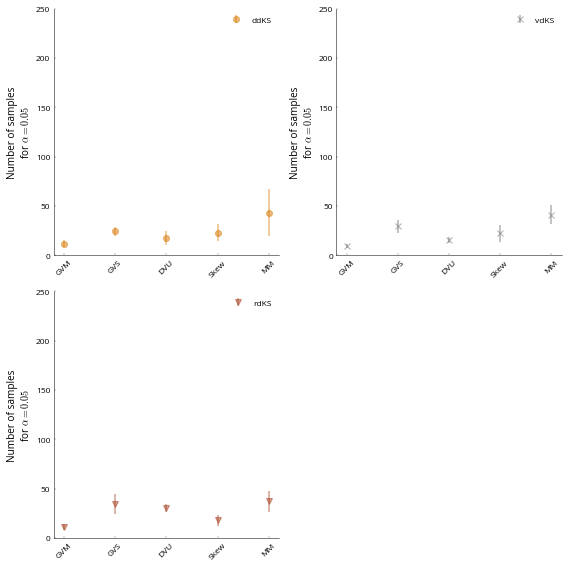

In [6]:
fig = plt.figure(figsize=(8, 8))
markers = ['o', 'x', 'v', '^']
#gvm
colors = ['#D77600', '#616265', '#A63F1E', '#F4AA00', '#007836', '#00338E', '#870150']
for i, (metric, marker, color) in enumerate(zip(data[list(data.keys())[0]].keys(), markers, colors)):
    plt.subplot(221+i)
    means = [data[_dataset][metric][0] for _dataset in data.keys()]
    stds = [data[_dataset][metric][1] for _dataset in data.keys()]
    plt.errorbar(np.arange(len(means)), means, yerr=stds, linestyle='none', color=color, marker=marker, label=metric, alpha=0.5)
    plt.xticks(np.arange(len(datasets)), ['GVM', 'GVS', 'DVU', 'Skew', 'MM', 'LS'], rotation=45)
    plt.ylabel('Number of samples' + "\n" + r'for $\alpha=0.05$')
    plt.ylim(0, 250)
    plt.legend()
plt.show()

ddKS
vdKS
rdKS


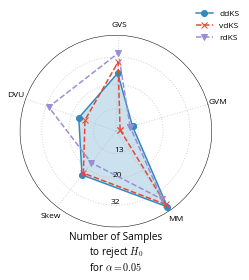

In [8]:
#markers = ['/', '\\', '|', '.']
theta = radar_factory(5, frame='circle')
fig, axs = plt.subplots(figsize=(4, 4), nrows=1, ncols=1,
                        subplot_kw=dict(projection='radar'))
rns = np.geomspace(1, 50, 10).astype(int)
rgrids = np.log10(rns)
plt.gca().set_rgrids(rgrids, labels=rns)
colors = ['#348ABD','#E24A33', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
for metric, marker, color in zip(data[list(data.keys())[0]].keys(), markers, colors):
    means = np.log10([data[_dataset][metric][0] for _dataset in data.keys()])
    stds = np.log10([data[_dataset][metric][1] for _dataset in data.keys()])
    if 'ddKS' in metric:
        linestyle = '-'
    else:
        linestyle = '--'
    line = plt.plot(theta, means, label=metric, color=color, linestyle=linestyle, marker=marker)
    print(metric)
    if 'ddKS' in metric:
        plt.fill(theta, means, alpha=0.25, facecolor=color)
plt.gca().set_xlabel('Number of Samples' + "\n" + r'to reject $H_{0}$' + "\n" + r'for $\alpha=0.05$')
plt.gca().set_rlabel_position(-90.0 - 20.0)
plt.gca().set_theta_offset(-6.0)
plt.gca().set_varlabels(['GVM', 'GVS', 'DVU', 'Skew', 'MM', 'LS'])
plt.grid(color='#AAAAAA', linewidth=1.0)
plt.legend(loc=(0.9, .95))
plt.savefig('n_samples_radar_xdks.pdf')
plt.show()